### Imports

Required packages including those needed for `image_arrays.py`, `hdf_utils.py`, `plot_utils.py`, `fitting.py`, and `lnl_modelling.py`.
- h5py
- numpy
- matplotlib
- scipy
- scikit-image
- symfit

In [1]:
import os
import re
import shutil
import sys
from datetime import date
from copy import deepcopy
import json

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle, Circle

from skimage import io
from scipy import signal
from scipy.interpolate import interp2d
from scipy import optimize

# local imports
from image_arrays import *
from hdf_utils import pack_hdf, unpack_hdf, Workspace
from fitting import BiexpFitter
from plot_utils import clean_axes
from lnl_modelling import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook
mpl.rcParams.update({"figure.max_open_warning": 0})  # suppress too many figures warning
mpl.rcParams["image.interpolation"] = "none"

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
data_path = os.path.join(base_path, "2022_12_14_processed_4x4/shifted_200/")
# data_path = os.path.join(base_path, "2022_12_14_processed_4x4/shifted_200_mask/")
# workspace_name = "workspace_4x4_prom0p6.h5"
# workspace_name = "workspace_2x2_prom0p6.h5"
workspace_name = "combined_4x4_prom0p6.h5"

# typically "DD" or "PD" referring to a folder. "epsc" is a special for non-imaging data.
depth = "DD" 
# depth = "epsc" 
depth_path = os.path.join(data_path, depth + "/")

exp = None  # if there is no further breakdown of data in the depth folder
# exp = "control"
# exp = "nbqx"
exp_path = depth_path if exp is None else os.path.join(depth_path, exp)

noise_path = os.path.join(data_path, "noise")

with open(os.path.join(exp_path, "conf.json")) as c:
    conf = json.load(c)
    
print("Configuration")
print("-------------")
for k, v in conf.items():
   print("%s:" % k, v) 

wrk = h5.File(os.path.join(data_path, workspace_name), mode="r")

Configuration
-------------
stim_width: 2200
stim_height: 2200
noise_freq: 5
noise_hz: 60
noise_start: 5.0
rec_hz: 58.25
rec_width: 221.0
rec_height: 118.07
x_cropped_pix: 16
y_cropped_pix: 0
x_reduce_pix: 4
y_reduce_pix: 4
rec_x_offset: 0.0
rec_y_offset: 0.0


In [4]:
# mask_path = os.path.join(base_path, "2022_12_14_processed_4x4/shifted_200_mask/")
# masked = h5.File(os.path.join(mask_path, workspace_name), mode="r")
# combo = h5.File(os.path.join(data_path, "combined_4x4_prom0p6.h5"), mode="w")
# combo.create_group("lead")
# combo["grid_w"] = wrk["grid_w"][()]
# combo["grid_h"] = wrk["grid_h"][()]
# combo["grid_locs"] = wrk["grid_locs"][:]
# combo["lead"]["xaxis"] = wrk["lead"]["xaxis"][:]
# combo["lead"]["n_events"] = wrk["lead"]["n_events"][:]
# combo["lead"]["pos_to_roi"] = wrk["lead"]["pos_to_roi"][:]
# s = wrk["lead"]["stack"].shape
# combo["lead"]["stack"] = np.zeros((s[0], s[1] * 2, *s[2:]))
# for i in range(s[0]):
#     combo["lead"]["stack"][i, 0] = wrk["lead"]["stack"][i, 0]
#     combo["lead"]["stack"][i, 1] = masked["lead"]["stack"][i, 0]

In [5]:
# combo.close()
# masked.close()

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [6]:
auto_transpose = True
h5_noise = False
downsampled_noise = True
noise_crop = 1480 # 1600

if h5_noise:
    def noise_loader(pth):
        with h5.File(pth) as f:
            data = f["stimulus"][()]
        return data
    raw_noise = np.stack(
        [
            noise_loader(os.path.join(noise_path, f))
            for f in os.listdir(noise_path) 
            if f.endswith(".h5")
        ],
        axis=0
    )
    # if time axis will always be the longest, if it's last, bring it up
    if auto_transpose and np.argmax(raw_noise.shape) == 3:
        raw_noise = raw_noise.transpose(0, 3, 1, 2)
else:
    raw_noise = np.stack(
        [
            io.imread(os.path.join(noise_path, f))
            for f in os.listdir(noise_path) 
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ], 
        axis=0
    )

raw_noise = (raw_noise if raw_noise.shape[0] > 1 else raw_noise[0]) / 255

# usual (flip both axes)
raw_noise = np.flip(raw_noise, axis=1)
raw_noise = np.flip(raw_noise, axis=2)

# raw_noise = raw_noise.transpose(0, 2, 1)
# raw_noise = np.rot90(raw_noise, k=2, axes=(1, 2))

# noise physical dimensions (microns)
stim_width = conf["stim_width"]
stim_height = conf["stim_height"]

if (noise_crop is not None and noise_crop < stim_width and noise_crop < stim_height):
    w = int(((stim_width - noise_crop) / stim_width) * raw_noise.shape[1] / 2)
    h = int(((stim_height - noise_crop) / stim_height) * raw_noise.shape[2] / 2)
    raw_noise = raw_noise[:, w:raw_noise.shape[1]-w, h:raw_noise.shape[2]-h]
    stim_width, stim_height = noise_crop, noise_crop

stim_extent = (0., stim_width, stim_height, 0.)

# noise timing
noise_freq = conf["noise_freq"]
cycle_dt = 1. / noise_freq
noise_hz = conf["noise_hz"]
cycle_frames = int(noise_hz / noise_freq)
noise_start = conf["noise_start"]

if downsampled_noise:
    raw_noise = np.repeat(raw_noise, int(noise_hz / noise_freq), axis=0)
    
noise_frames, noise_cols, noise_rows = raw_noise.shape
noise_xaxis = np.arange(noise_frames) * (1 / noise_hz) + noise_start
noise_end = np.max(noise_xaxis)
noise_frame_times = np.array([
    noise_start + (1 / noise_freq) * i 
    for i in range(raw_noise.shape[0] // cycle_frames + 1)
])

print("raw noise shape:", raw_noise.shape)

raw noise shape: (17988, 60, 60)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


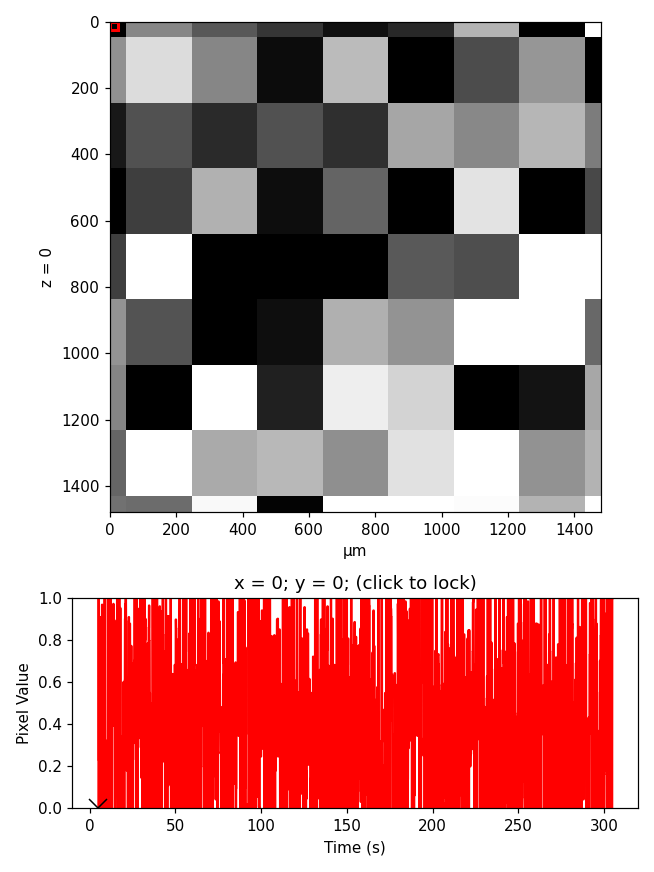

In [7]:
raw_noise_plot = StackExplorer(
    raw_noise,
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)
raw_noise_plot.ax[0].set_xlabel("µm")
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.tight_layout()
raw_noise_plot.fig.show()

<IPython.core.display.Javascript object>


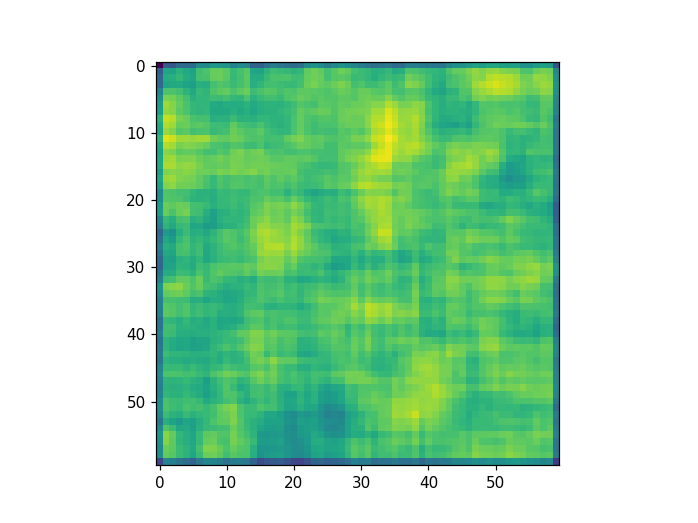

In [8]:
nz_mean_fig, nz_mean_ax = plt.subplots(1)
nz_mean_ax.imshow(np.mean(raw_noise, axis=0))

### Select (and display) recording to analyse here.
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`). While moving around the ROI, one may left-click to lock it in the current position, allowing interaction with the z-projection axis underneath.

In [9]:
hz = conf["rec_hz"]
dt = 1 / hz

def unpack(pth):
    with h5.File(pth) as f:
        data = unpack_hdf(f)["stack"]
    return data

if depth == "epsc":
    stacks = np.stack(
        [
            np.loadtxt(os.path.join(exp_path, f), skiprows=1)
            for f in os.listdir(exp_path) 
            if f.endswith(".csv")
        ],
        axis=0
    )
    stacks = stacks.reshape(*stacks.shape, 1, 1) * -1
else:
    stacks = np.stack(
        [
            unpack(os.path.join(exp_path, f))
            for f in os.listdir(exp_path) 
            if f.endswith(".h5")
        ],
        axis=0
    )

print(stacks.shape)
n_trials, n_pts, stack_rows, stack_cols = stacks.shape
mean_stack_proj = bn.nanmean(bn.nanmean(stacks, axis=0), axis=0)

recs_xaxis = np.arange(n_pts) * dt
stim_start_idx = nearest_index(recs_xaxis, noise_xaxis.min())
stim_end_idx = nearest_index(recs_xaxis, noise_xaxis.max())
rec_pts_per_cycle = int(hz / noise_freq)

##### physical dimensions (in microns)
# width and height kept from full scan field (cropped in preprocessing)
x_crop_ratio = (stack_cols - (conf["x_cropped_pix"] / conf["x_reduce_pix"])) / stack_cols
y_crop_ratio = (stack_rows - (conf["y_cropped_pix"] / conf["y_reduce_pix"])) / stack_rows

rec_width = conf["rec_width"] *  x_crop_ratio
rec_height = conf["rec_height"] * y_crop_ratio
rec_x_offset = conf["rec_x_offset"]
rec_y_offset = conf["rec_y_offset"]
rec_extent = (0, rec_width, rec_height, 0)  # for scaling imshow plots

print("stacks shape:", stacks.shape)

(1, 18000, 64, 56)
stacks shape: (1, 18000, 64, 56)


### Dynamic ROI plot of recordings

Trial to display in the stack axis can be selected with the slider, with the last position being the average. The currently selected trial will be highlighted in **red**. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

- `delta` sets the number of timesteps/frames that are scrolled per tick
- `roi_size` sets dynamic ROI size in pixels. This can either be scalar (e.g. `1`), or a tuple (e.g. `(1, 2)`) if you want a non-square ROI 

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


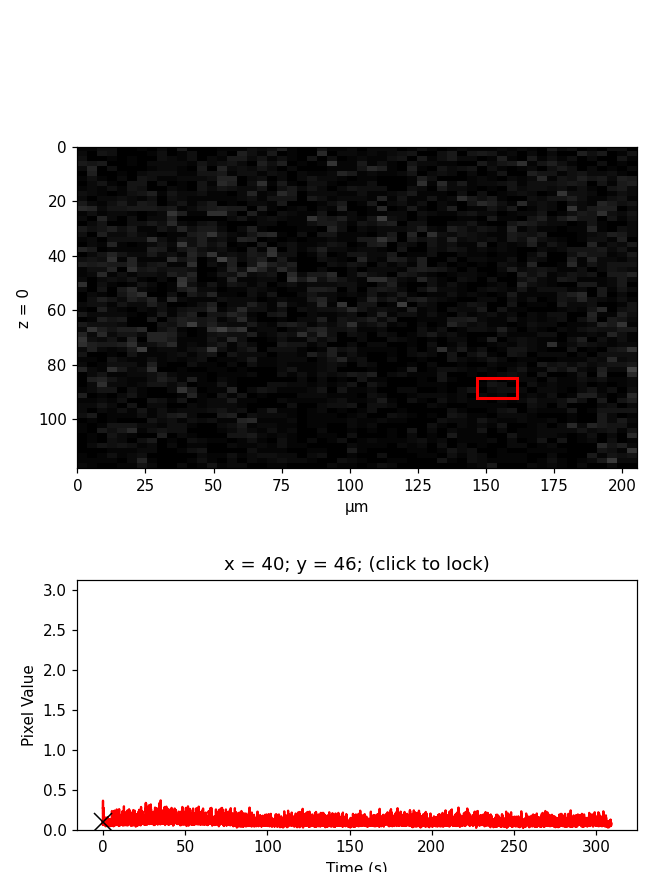

Recording shape: (18000, 64, 56)


In [10]:
stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=4,
    dims=(rec_width, rec_height),
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[0].set_xlabel("µm")
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)

<IPython.core.display.Javascript object>


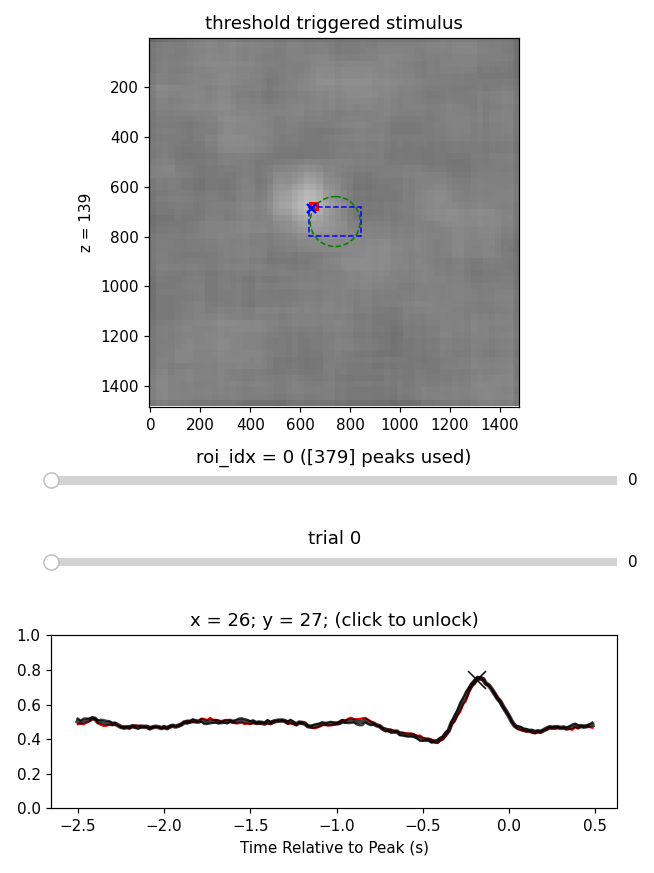

In [11]:
lead = wrk["lead"]
n_kept_rois = lead["stack"].shape[0]

def roi_fmt_fun(i):
    return "roi_idx = %i (%s peaks used)" % (lead["pos_to_roi"][i], str(lead["n_events"][i]))

if n_kept_rois == 1:
    print("Sole ROI (%s peaks used)" % str(lead["n_events"][0]))
    
lead_stack_plot = StackExplorer(
    lead["stack"],
    zaxis=lead["xaxis"][:],
    delta=2,
    roi_sz=(1, 1),
    vmin=0.,
    vmax=1.,
    n_fmt_fun=roi_fmt_fun,
    dims=(stim_width, stim_height),
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

half_w = wrk["grid_w"][()] / 2
half_h = wrk["grid_h"][()] / 2
col_x = rec_width / stack_cols
row_y = rec_height / stack_rows
x_corner = (stim_width - rec_width) / 2 + rec_x_offset
y_corner = (stim_height - rec_height) / 2 + rec_y_offset

def scan_field_rect():
    return Rectangle(
        (x_corner - .5, y_corner - .5),  # grid offset
        rec_width, 
        rec_height, 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )

def mask_outline(r):
    return Circle(
        (stim_width / 2, stim_height / 2),
        r,
        fill=False,
        color="green",
        linewidth=1,
        linestyle="--",
    )

def update_roi_mark(mark):
    def f(i):
        idx = lead["pos_to_roi"][int(i)]
        x, y = wrk["grid_locs"][idx]
        x = (x + half_w) * col_x + x_corner 
        y = (y + half_h) * row_y + y_corner 
        mark.set_offsets([[x, y]])
    return f

lead_stack_plot.ax[0].add_patch(scan_field_rect())
lead_stack_plot.ax[0].add_patch(mask_outline(100))
lead_roi_mark = lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(lead_roi_mark)(0)    
if lead_stack_plot.n_sz > 1:
    lead_stack_plot.n_slider.on_changed(update_roi_mark(lead_roi_mark))

lead_stack_plot.fig.show()

<IPython.core.display.Javascript object>


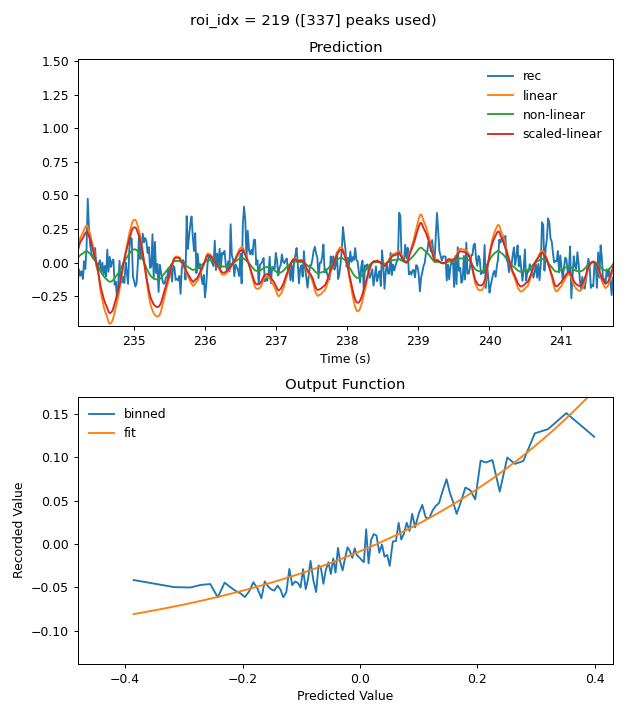

In [13]:
overlay_waves = {
    "Prediction": {
        "rec": wrk["actual"],
        "linear": wrk["lin_pred"]["pred"],
        "non-linear": wrk["outf"]["nonlinear"],
        "scaled-linear": wrk["lin_pred"]["scaled"],
    },
    "Output Function": {
        "binned": wrk["outf"]["resp_bins"],
        "fit": wrk["outf"]["fit_y"],
    }
}
overlay_xaxes = {
    "Prediction": {
        "rec": recs_xaxis,
        "linear": wrk["lin_pred"]["xaxis"][:],
        "non-linear": wrk["lin_pred"]["xaxis"][:],
        "scaled-linear": wrk["lin_pred"]["xaxis"][:],
    },
    "Output Function": {
        "binned": wrk["outf"]["pred_bins"],
        "fit": wrk["outf"]["fit_x"],
    }
}
overlay_plot = MultiOverlayPlotter(
    overlay_waves,
    overlay_xaxes,
    idx_fmt_fun=roi_fmt_fun,
    autoscale=False,
#     alpha=0.8,
    figsize=(7, 8)
)
overlay_plot.ax[0].set_xlabel("Time (s)")
overlay_plot.ax[1].set_xlabel("Predicted Value")
overlay_plot.ax[1].set_ylabel("Recorded Value")
overlay_plot.fig.tight_layout()

In [14]:
wrk.close()